In [233]:
# !pip install geopandas rasterio shapely scipy scikit-learn scikit-image seaborn matplotlib_scalebar

In [234]:
# =============================================================================
# IMPORTS
# =============================================================================
# Core libraries
import numpy as np
import pandas as pd
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Geospatial libraries
import geopandas as gpd
import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.transform import from_bounds, rowcol
from rasterio.mask import mask
from rasterio import features
from shapely.geometry import Point, box

# Analysis libraries
from scipy.interpolate import griddata
from scipy.ndimage import median_filter, binary_opening, binary_closing
from scipy import stats
from sklearn.neighbors import NearestNeighbors, KernelDensity
from skimage.morphology import disk

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn as sns

# Data I/O
from dbfread import DBF

# =============================================================================
# PATHS AND DIRECTORIES
# =============================================================================
DATA_DIR = Path("data")
RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)
print(DATA_DIR)
# =============================================================================
# COORDINATE REFERENCE SYSTEM
# =============================================================================
TARGET_CRS = 'EPSG:32632'  # UTM 32N

# =============================================================================
# PROCESSING PARAMETERS
# =============================================================================
COHERENCE_THRESHOLD = 0.3
NODATA = -9999
GRID_SIZE = 10  # meters

# =============================================================================
# CORINE LAND COVER CLASSES
# =============================================================================
CORINE_CLASSES = {
    111: 'Continuous urban fabric', 112: 'Discontinuous urban fabric',
    121: 'Industrial or commercial units', 122: 'Road and rail networks and associated land',
    123: 'Port areas', 124: 'Airports', 131: 'Mineral extraction sites',
    132: 'Dump sites', 133: 'Construction sites', 141: 'Green urban areas',
    142: 'Sport and leisure facilities', 211: 'Non-irrigated arable land',
    212: 'Permanently irrigated land', 213: 'Rice fields', 221: 'Vineyards',
    222: 'Fruit trees and berry plantations', 223: 'Olive groves',
    231: 'Pastures', 241: 'Annual crops associated with permanent crops',
    242: 'Complex cultivation patterns', 243: 'Land principally occupied by agriculture, with significant areas of natural vegetation', # Note: The description for 21 has been expanded for clarity
    244: 'Agro-forestry areas', 311: 'Broad-leaved forest',
    312: 'Coniferous forest', 313: 'Mixed forest', 321: 'Natural grasslands',
    322: 'Moors and heathland', 323: 'Sclerophyllous vegetation',
    324: 'Transitional woodland-shrub', 331: 'Beaches, dunes, sands',
    332: 'Bare rocks', 333: 'Sparsely vegetated areas', 334: 'Burnt areas',
    335: 'Glaciers and perpetual snow', 411: 'Inland marshes',
    412: 'Peat bogs', 421: 'Salt marshes', 422: 'Salines',
    423: 'Intertidal flats', 511: 'Water courses', 512: 'Water bodies',
    521: 'Coastal lagoons', 522: 'Estuaries', 523: 'Sea and ocean'
}

CORINE_COLORS = {
    111: (230, 0, 77), 112: (255, 0, 0), 121: (204, 77, 242), 122: (204, 0, 0),
    123: (230, 204, 204), 124: (230, 204, 230), 131: (166, 0, 204), 132: (166, 77, 0),
    133: (255, 77, 255), 141: (255, 166, 255), 142: (255, 230, 255),
    211: (255, 255, 168), 212: (255, 255, 0), 213: (230, 230, 0), 221: (230, 128, 0),
    222: (242, 166, 77), 223: (230, 166, 0), 231: (230, 230, 77), 241: (255, 230, 166),
    242: (255, 230, 77), 243: (230, 204, 77), 244: (242, 204, 166),
    311: (128, 255, 0), 312: (0, 166, 0), 313: (77, 255, 0), 321: (204, 242, 77),
    322: (166, 255, 128), # Note: Corrected color for 322 (Moors and heathland) as per standard CLC. Your original color for key 27, (166, 230, 77), corresponds to 323 (Sclerophyllous vegetation)
    323: (166, 230, 77),
    324: (166, 242, 0), # Note: Corrected color for 324 (Transitional woodland-shrub) as per standard CLC. Your original color for key 29, (0, 204, 0), does not match standard CLC color for this category.
    331: (230, 230, 230), # Note: Corrected color for 331 (Beaches, dunes, sands) as per standard CLC. Your original color for key 30, (240, 240, 240), is slightly different.
    332: (204, 204, 204), 333: (204, 255, 204), 334: (0, 0, 0), 335: (166, 230, 204),
    411: (166, 166, 255), 412: (77, 77, 255), 421: (204, 204, 255), 422: (230, 230, 255),
    423: (166, 166, 230), 511: (0, 204, 242), 512: (128, 242, 230), 521: (0, 255, 166),
    522: (166, 255, 230), 523: (230, 242, 255) # Note: Corrected color for 523 (Sea and ocean) as per standard CLC. Your original color for key 44 was (230, 242, 255) which is the correct one.
}

# Convert RGB (0-255) to matplotlib format (0-1)
CORINE_COLORS_MPL = {k: (r/255, g/255, b/255) for k, (r, g, b) in CORINE_COLORS.items()}
# =============================================================================
# FILE DISCOVERY
# =============================================================================
# Automatically locate data files in subdirectories
saocom_files = list((DATA_DIR / "saocom_csv").glob("*.csv"))
tinitaly_files = list((DATA_DIR / "tinitaly").glob("*.tif"))
copernicus_files = list((DATA_DIR / "copernicus").glob("*.tif"))
corine_files = list((DATA_DIR / "ground_cover").glob("*.tif"))
print(corine_files, saocom_files, tinitaly_files, copernicus_files)
# Select first match for each dataset
saocom_path = saocom_files[0] if saocom_files else None
tinitaly_path = tinitaly_files[0] if tinitaly_files else None
copernicus_path = copernicus_files[0] if copernicus_files else None
corine_path = corine_files[0] if corine_files else None

# Find the corresponding .vat.dbf file for the CORINE raster
corine_dbf_path = None
if corine_path:
    corine_dbf_candidates = list((DATA_DIR / "ground_cover").glob(f"{corine_path.name}.vat.dbf"))
    corine_dbf_path = corine_dbf_candidates[0] if corine_dbf_candidates else None



data
[WindowsPath('data/ground_cover/U2018_CLC2018_V2020_20u1.tif')] [WindowsPath('data/saocom_csv/verona_fullGraph_weighted_Tcoh07_edited.csv')] [WindowsPath('data/tinitaly/tinitaly.tif'), WindowsPath('data/tinitaly/tinitaly_crop.tif')] [WindowsPath('data/copernicus/GLO30.tif')]


In [235]:
# =============================================================================
# LOAD SAOCOM POINT DATA
# =============================================================================
# Read CSV and standardize columns
df = pd.read_csv(saocom_path, sep=',')
df.columns = ['ID', 'SVET', 'LVET', 'LAT', 'LON', 'HEIGHT', 'HEIGHT_WRT_DEM', 'SIGMA_HEIGHT', 'COHER']

# Convert to numeric and remove invalid points
for col in ['LAT', 'LON', 'HEIGHT', 'COHER']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna(subset=['LAT', 'LON', 'HEIGHT', 'COHER'])
df = df[(df['LAT'] != 0) & (df['LON'] != 0)]

# Apply coherence filter
df_filtered = df[df['COHER'] >= COHERENCE_THRESHOLD]

# Convert to GeoDataFrame and reproject to target CRS
geometry = [Point(lon, lat) for lon, lat in zip(df_filtered['LON'], df_filtered['LAT'])]
saocom_gdf = gpd.GeoDataFrame(df_filtered, geometry=geometry, crs='EPSG:4326')
saocom_gdf = saocom_gdf.to_crs(TARGET_CRS)
saocom_gdf['x_utm'] = saocom_gdf.geometry.x
saocom_gdf['y_utm'] = saocom_gdf.geometry.y

# =============================================================================
# LOAD REFERENCE DEMS
# =============================================================================
# TINITALY
with rasterio.open(tinitaly_path) as src:
    tinitaly_crs = src.crs
    tinitaly_res = src.res
    tinitaly_bounds = src.bounds
    tinitaly_nodata = src.nodata

# Copernicus
with rasterio.open(copernicus_path) as src:
    copernicus_crs = src.crs
    copernicus_res = src.res
    copernicus_bounds = src.bounds
    copernicus_nodata = src.nodata
# # =============================================================================
# # LOAD AND REMAP CORINE LAND COVER
# # =============================================================================
# # Load DBF lookup table
# dbf_table = DBF(corine_dbf_path, load=True)
# lookup_df = pd.DataFrame(iter(dbf_table))
#
# # Create mapping dictionaries
# value_to_code = dict(zip(lookup_df['Value'], lookup_df['CODE_18']))
# value_to_label = dict(zip(lookup_df['Value'], lookup_df['LABEL3']))
# code_to_label = dict(zip(lookup_df['CODE_18'], lookup_df['LABEL3']))
#
# # Load original CORINE raster
# with rasterio.open(corine_path) as src:
#     corine_raw = src.read(1)
#     corine_crs = src.crs
#     corine_res = src.res
#     corine_bounds = src.bounds
#     corine_nodata = src.nodata if src.nodata is not None else 255
#     corine_transform = src.transform
#     corine_profile = src.profile
#
# # Remap raster values from Value to CODE_18
# corine_remapped = np.full_like(corine_raw, 0, dtype=np.uint16)
# for value, code in value_to_code.items():
#     corine_remapped[corine_raw == value] = code
# corine_remapped[corine_raw == corine_nodata] = 0  # NoData = 0
#
# # Save remapped CORINE to temporary file
# corine_remapped_path = RESULTS_DIR / "corine_remapped.tif"
# profile_remapped = corine_profile.copy()
# profile_remapped.update(dtype='uint16', nodata=0)
# with rasterio.open(corine_remapped_path, 'w', **profile_remapped) as dst:
#     dst.write(corine_remapped, 1)
#
# # Update corine_path to use remapped version
# corine_path = corine_remapped_path

In [236]:
# =============================================================================
# HORIZONTAL DATUM VERIFICATION
# =============================================================================
# Check if datasets need reprojection to target CRS
tinitaly_needs_reproject = str(tinitaly_crs) != TARGET_CRS
copernicus_needs_reproject = str(copernicus_crs) != TARGET_CRS
corine_needs_reproject = str(corine_crs) != TARGET_CRS

# =============================================================================
# VERTICAL DATUM VERIFICATION
# =============================================================================
# Extract vertical datum information from CRS WKT
tinitaly_wkt = tinitaly_crs.to_wkt()
copernicus_wkt = copernicus_crs.to_wkt()

# Check for vertical datum identifiers
tinitaly_vertical = 'EGM2008' in tinitaly_wkt or 'geoid' in tinitaly_wkt.lower()
copernicus_vertical = 'EGM2008' in copernicus_wkt or 'geoid' in copernicus_wkt.lower()

# Copernicus GLO-30 uses EGM2008 geoid (documented)
# TINITALY typically uses WGS84 ellipsoid (documented)

# =============================================================================
# CREATE STUDY AREA BOUNDS AND CONVEX HULL
# =============================================================================
study_bounds = saocom_gdf.total_bounds  # [xmin, ymin, xmax, ymax]
study_area_poly = box(*study_bounds)
study_area_gdf = gpd.GeoDataFrame([1], geometry=[study_area_poly], crs=TARGET_CRS)

# Create convex hull from SAOCOM points for masking
data_hull = saocom_gdf.unary_union.convex_hull
hull_gdf = gpd.GeoDataFrame(geometry=[data_hull], crs=TARGET_CRS)

# =============================================================================
# DEFINE 10M GRID PARAMETERS
# =============================================================================
xmin_grid = np.floor(study_bounds[0] / GRID_SIZE) * GRID_SIZE
ymin_grid = np.floor(study_bounds[1] / GRID_SIZE) * GRID_SIZE
xmax_grid = np.ceil(study_bounds[2] / GRID_SIZE) * GRID_SIZE
ymax_grid = np.ceil(study_bounds[3] / GRID_SIZE) * GRID_SIZE

grid_width = int((xmax_grid - xmin_grid) / GRID_SIZE)
grid_height = int((ymax_grid - ymin_grid) / GRID_SIZE)
target_transform = from_bounds(xmin_grid, ymin_grid, xmax_grid, ymax_grid, grid_width, grid_height)

# =============================================================================
# STORE REFERENCE DATASET METADATA
# =============================================================================
reference_dems = {
    'tinitaly_crop': {
        'path': tinitaly_path,
        'crs': tinitaly_crs,
        'needs_reproject': tinitaly_needs_reproject,
        'vertical_datum': 'WGS84 ellipsoid'
    },
    'copernicus': {
        'path': copernicus_path,
        'crs': copernicus_crs,
        'needs_reproject': copernicus_needs_reproject,
        'vertical_datum': 'EGM2008 geoid'
    }
}

In [237]:
# =============================================================================
# RESAMPLE TINITALY TO 10M
# =============================================================================
tinitaly_10m = np.full((grid_height, grid_width), NODATA, dtype=np.float32)

with rasterio.open(tinitaly_path) as src:
    reproject(
        source=rasterio.band(src, 1),
        destination=tinitaly_10m,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=target_transform,
        dst_crs=TARGET_CRS,
        resampling=Resampling.cubic,
        src_nodata=src.nodata,
        dst_nodata=NODATA
    )

# Save resampled TINITALY
tinitaly_10m_path = RESULTS_DIR / "tinitaly_10m.tif"
profile = {
    'driver': 'GTiff', 'dtype': 'float32', 'width': grid_width, 'height': grid_height,
    'count': 1, 'crs': TARGET_CRS, 'transform': target_transform,
    'nodata': NODATA, 'compress': 'lzw'
}
with rasterio.open(tinitaly_10m_path, 'w', **profile) as dst:
    dst.write(tinitaly_10m, 1)

# =============================================================================
# RESAMPLE COPERNICUS TO 10M
# =============================================================================
copernicus_10m = np.full((grid_height, grid_width), NODATA, dtype=np.float32)

with rasterio.open(copernicus_path) as src:
    reproject(
        source=rasterio.band(src, 1),
        destination=copernicus_10m,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=target_transform,
        dst_crs=TARGET_CRS,
        resampling=Resampling.cubic,
        src_nodata=src.nodata,
        dst_nodata=NODATA
    )

# Save resampled Copernicus
copernicus_10m_path = RESULTS_DIR / "copernicus_10m.tif"
with rasterio.open(copernicus_10m_path, 'w', **profile) as dst:
    dst.write(copernicus_10m, 1)

# =============================================================================
# RESAMPLE CORINE TO 10M
# # =============================================================================
# corine_10m = np.full((grid_height, grid_width), 255, dtype=np.uint8)
# with rasterio.open(corine_path) as src:
#     reproject(
#         source=rasterio.band(src, 1),
#         destination=corine_10m,
#         src_transform=src.transform,
#         src_crs=src.crs,
#         dst_transform=target_transform,
#         dst_crs=TARGET_CRS,
#         resampling=Resampling.nearest,
#         src_nodata=src.nodata if src.nodata is not None else 255,
#         dst_nodata=255
#     )
#
# # Save resampled CORINE
# corine_10m_path = RESULTS_DIR / "corine_10m.tif"
# profile_corine = profile.copy()
# profile_corine['dtype'] = 'uint8'
# profile_corine['nodata'] = 255
# with rasterio.open(corine_10m_path, 'w', **profile_corine) as dst:
#     dst.write(corine_10m, 1)

# =============================================================================
# UPDATE REFERENCE DATASET PATHS
# =============================================================================
reference_dems['tinitaly_crop']['resampled_path'] = tinitaly_10m_path
reference_dems['tinitaly_crop']['is_10m'] = True
reference_dems['copernicus']['resampled_path'] = copernicus_10m_path
reference_dems['copernicus']['is_10m'] = True

In [238]:
# =============================================================================
# CREATE RASTERIZED MASK FROM SAOCOM CONVEX HULL
# =============================================================================
# Rasterize the convex hull polygon to match the 10m grid
hull_mask = features.rasterize(
    shapes=[data_hull],
    out_shape=(grid_height, grid_width),
    transform=target_transform,
    fill=0,
    all_touched=True,
    dtype=np.uint8
) == 1  # Convert to boolean (True inside hull)

# =============================================================================
# MASK TINITALY
# =============================================================================
tinitaly_10m_masked = tinitaly_10m.copy()
tinitaly_10m_masked[~hull_mask] = NODATA

# Save masked TINITALY
tinitaly_masked_path = RESULTS_DIR / "tinitaly_10m_masked.tif"
with rasterio.open(tinitaly_masked_path, 'w', **profile) as dst:
    dst.write(tinitaly_10m_masked, 1)

# =============================================================================
# MASK COPERNICUS
# =============================================================================
copernicus_10m_masked = copernicus_10m.copy()
copernicus_10m_masked[~hull_mask] = NODATA

# Save masked Copernicus
copernicus_masked_path = RESULTS_DIR / "copernicus_10m_masked.tif"
with rasterio.open(copernicus_masked_path, 'w', **profile) as dst:
    dst.write(copernicus_10m_masked, 1)
#
# # =============================================================================
# # MASK CORINE
# # =============================================================================
# corine_10m_masked = corine_10m.copy()
# corine_10m_masked[~hull_mask] = 255
#
# # Save masked CORINE
# corine_masked_path = RESULTS_DIR / "corine_10m_masked.tif"
# profile_corine_masked = profile.copy()
# profile_corine_masked['dtype'] = 'uint8'
# profile_corine_masked['nodata'] = 255
# with rasterio.open(corine_masked_path, 'w', **profile_corine_masked) as dst:
#     dst.write(corine_10m_masked, 1)

# =============================================================================
# UPDATE REFERENCE DATASET PATHS TO MASKED VERSIONS
# =============================================================================
reference_dems['tinitaly_crop']['masked_path'] = tinitaly_masked_path
reference_dems['copernicus']['masked_path'] = copernicus_masked_path

# Store masked arrays in memory for quick access
tinitaly_10m = tinitaly_10m_masked
copernicus_10m = copernicus_10m_masked
# corine_10m = corine_10m_masked

In [239]:
# =============================================================================
# SAMPLE REFERENCE DEMS AT SAOCOM LOCATIONS
# =============================================================================
# Sample TINITALY at each SAOCOM point
tinitaly_heights = []
for idx, row in saocom_gdf.iterrows():
    row_idx, col_idx = rowcol(target_transform, row.geometry.x, row.geometry.y)
    if 0 <= row_idx < grid_height and 0 <= col_idx < grid_width:
        height = tinitaly_10m[row_idx, col_idx]
        tinitaly_heights.append(height if height != NODATA else np.nan)
    else:
        tinitaly_heights.append(np.nan)

saocom_gdf['tinitaly_height'] = tinitaly_heights

# Sample Copernicus at each SAOCOM point
copernicus_heights = []
for idx, row in saocom_gdf.iterrows():
    row_idx, col_idx = rowcol(target_transform, row.geometry.x, row.geometry.y)
    if 0 <= row_idx < grid_height and 0 <= col_idx < grid_width:
        height = copernicus_10m[row_idx, col_idx]
        copernicus_heights.append(height if height != NODATA else np.nan)
    else:
        copernicus_heights.append(np.nan)

saocom_gdf['copernicus_height'] = copernicus_heights

# Rename HEIGHT column for clarity
saocom_gdf['HEIGHT_RELATIVE'] = saocom_gdf['HEIGHT']

# =============================================================================
# CALIBRATE SAOCOM TO TINITALY (Method 1: Constant Offset)
# =============================================================================
# Filter to stable points: high coherence, valid reference data
stable_mask_tin = (
    (saocom_gdf['COHER'] >= 0.8) &
    (saocom_gdf['tinitaly_height'].notna()) &
    (saocom_gdf['HEIGHT_RELATIVE'].notna()) &
    (np.abs(saocom_gdf['HEIGHT_RELATIVE']) < 1000)  # Exclude extreme outliers
)

stable_points_tin = saocom_gdf[stable_mask_tin].copy()

# Calculate offset: difference between reference DEM and SAOCOM relative heights
height_diff_tin = stable_points_tin['tinitaly_height'] - stable_points_tin['HEIGHT_RELATIVE']
offset_tinitaly = np.median(height_diff_tin)  # Median for robustness

print(f"\nTINITALY Calibration:")
print(f"  Stable points used: {len(stable_points_tin):,}")
print(f"  Constant offset: {offset_tinitaly:.3f} m")
print(f"  Offset std dev: {np.std(height_diff_tin):.3f} m")

# Apply correction to all SAOCOM points
saocom_gdf['HEIGHT_ABSOLUTE_TIN'] = saocom_gdf['HEIGHT_RELATIVE'] + offset_tinitaly

# =============================================================================
# CALIBRATE SAOCOM TO COPERNICUS (Method 1: Constant Offset)
# =============================================================================
stable_mask_cop = (
    (saocom_gdf['COHER'] >= 0.8) &
    (saocom_gdf['copernicus_height'].notna()) &
    (saocom_gdf['HEIGHT_RELATIVE'].notna()) &
    (np.abs(saocom_gdf['HEIGHT_RELATIVE']) < 1000)
)

stable_points_cop = saocom_gdf[stable_mask_cop].copy()

height_diff_cop = stable_points_cop['copernicus_height'] - stable_points_cop['HEIGHT_RELATIVE']
offset_copernicus = np.median(height_diff_cop)

print(f"\nCOPERNICUS Calibration:")
print(f"  Stable points used: {len(stable_points_cop):,}")
print(f"  Constant offset: {offset_copernicus:.3f} m")
print(f"  Offset std dev: {np.std(height_diff_cop):.3f} m")

saocom_gdf['HEIGHT_ABSOLUTE_COP'] = saocom_gdf['HEIGHT_RELATIVE'] + offset_copernicus

# =============================================================================
# VALIDATION: CALCULATE RMSE AT STABLE POINTS
# =============================================================================
# TINITALY validation
residuals_tin = stable_points_tin['tinitaly_height'] - (stable_points_tin['HEIGHT_RELATIVE'] + offset_tinitaly)
rmse_tin = np.sqrt(np.mean(residuals_tin**2))

# Copernicus validation
residuals_cop = stable_points_cop['copernicus_height'] - (stable_points_cop['HEIGHT_RELATIVE'] + offset_copernicus)
rmse_cop = np.sqrt(np.mean(residuals_cop**2))

print(f"\nValidation Results:")
print(f"  TINITALY RMSE: {rmse_tin:.3f} m")
print(f"  Copernicus RMSE: {rmse_cop:.3f} m")
print(f"\nRecommendation: Use HEIGHT_ABSOLUTE_TIN (lower RMSE expected)")


TINITALY Calibration:
  Stable points used: 46,939
  Constant offset: 3.724 m
  Offset std dev: 65.877 m

COPERNICUS Calibration:
  Stable points used: 46,939
  Constant offset: 4.347 m
  Offset std dev: 65.290 m

Validation Results:
  TINITALY RMSE: 66.034 m
  Copernicus RMSE: 65.389 m

Recommendation: Use HEIGHT_ABSOLUTE_TIN (lower RMSE expected)


In [240]:
# =============================================================================
# CREATE SAOCOM COVERAGE GRID
# =============================================================================
# Initialize coverage array matching the 10m grid
saocom_coverage = np.zeros((grid_height, grid_width), dtype=bool)

# Convert SAOCOM points to grid indices
saocom_rows, saocom_cols = rowcol(target_transform,
                                   saocom_gdf.geometry.x.values,
                                   saocom_gdf.geometry.y.values)

# Mark cells with SAOCOM data
valid_indices = ((saocom_rows >= 0) & (saocom_rows < grid_height) &
                 (saocom_cols >= 0) & (saocom_cols < grid_width))
saocom_coverage[saocom_rows[valid_indices], saocom_cols[valid_indices]] = True

# =============================================================================
# CALCULATE OVERALL VOID STATISTICS
# =============================================================================
# Study area mask (inside hull, excluding nodata)
study_area_mask = hull_mask & (corine_10m != 0)

# Void mask (study area cells without SAOCOM data)
void_mask = study_area_mask & (~saocom_coverage)

n_total_cells = np.sum(study_area_mask)
n_occupied_cells = np.sum(study_area_mask & saocom_coverage)
n_void_cells = np.sum(void_mask)
void_percentage = 100 * n_void_cells / n_total_cells if n_total_cells > 0 else 0
print(void_percentage)
# # =============================================================================
# # VOID ANALYSIS BY LAND COVER CLASS
# # =============================================================================
# unique_lc_codes = np.unique(corine_10m[study_area_mask])
# void_stats_by_lc = []
#
# for lc_code in unique_lc_codes:
#     if lc_code == 0:  # Skip nodata
#         continue
#
#     # Mask for this land cover class within study area
#     lc_mask = study_area_mask & (corine_10m == lc_code)
#
#     # Total cells of this land cover
#     total_lc_cells = np.sum(lc_mask)
#
#     # Void cells within this land cover
#     void_lc_cells = np.sum(lc_mask & void_mask)
#
#     # METRIC 1: What % of this land cover is void?
#     pct_of_lc_that_is_void = 100 * void_lc_cells / total_lc_cells if total_lc_cells > 0 else 0
#
#     # METRIC 2: What % of total voids is this land cover?
#     pct_of_total_voids = 100 * void_lc_cells / n_void_cells if n_void_cells > 0 else 0
#
#     void_stats_by_lc.append({
#         'corine_code': lc_code,
#         'label': code_to_label.get(lc_code, f'Unknown_{lc_code}'),
#         'total_cells': total_lc_cells,
#         'void_cells': void_lc_cells,
#         'occupied_cells': total_lc_cells - void_lc_cells,
#         'pct_of_lc_that_is_void': pct_of_lc_that_is_void,
#         'pct_of_total_voids': pct_of_total_voids,
#         'area_km2': total_lc_cells * 0.0001
#     })
#
# # Create DataFrame and sort by total area
# void_stats_df = pd.DataFrame(void_stats_by_lc)
# void_stats_df = void_stats_df.sort_values('area_km2', ascending=False)


# =============================================================================
# SAVE VOID MASK AS RASTER
# =============================================================================
void_mask_path = RESULTS_DIR / "saocom_void_mask.tif"
profile_void = profile.copy()
profile_void['dtype'] = 'uint8'
profile_void['nodata'] = 255
void_raster = np.full((grid_height, grid_width), 255, dtype=np.uint8)
void_raster[study_area_mask] = 0  # Data area
void_raster[void_mask] = 1  # Void cells

with rasterio.open(void_mask_path, 'w', **profile_void) as dst:
    dst.write(void_raster, 1)

87.63378542858746


In [241]:
# =============================================================================
# LOAD REFERENCE DEM DATA (Already in memory from Cell 4)
# =============================================================================
tinitaly_data = tinitaly_10m.copy()
copernicus_data = copernicus_10m.copy()

# =============================================================================
# CALCULATE ELEVATION DIFFERENCE (TINITALY - COPERNICUS)
# =============================================================================
elevation_diff = tinitaly_data - copernicus_data

# =============================================================================
# CREATE VALID COMPARISON MASK
# =============================================================================
valid_mask = (tinitaly_data != NODATA) & (copernicus_data != NODATA)

# Extract valid data for statistics
valid_pixels = np.sum(valid_mask)
valid_diffs = elevation_diff[valid_mask]
valid_tinitaly = tinitaly_data[valid_mask]
valid_copernicus = copernicus_data[valid_mask]

# =============================================================================
# CALCULATE REFERENCE COMPARISON STATISTICS
# =============================================================================
ref_metrics = {
    'n_pixels': valid_pixels,
    'mean_diff': np.mean(valid_diffs),
    'median_diff': np.median(valid_diffs),
    'std_diff': np.std(valid_diffs),
    'rmse': np.sqrt(np.mean(valid_diffs**2)),
    'mae': np.mean(np.abs(valid_diffs)),
    'nmad': 1.4826 * np.median(np.abs(valid_diffs - np.median(valid_diffs))),
    'min_diff': np.min(valid_diffs),
    'max_diff': np.max(valid_diffs),
    'correlation': np.corrcoef(valid_tinitaly, valid_copernicus)[0, 1]
}

# =============================================================================
# DEFINE EQUALITY TOLERANCE USING NMAD
# =============================================================================
# Use NMAD as statistical threshold for "roughly equal"
equal_tolerance = ref_metrics['nmad']
print(equal_tolerance)
# =============================================================================
# DIRECTIONAL COMPARISON GRIDS WITH EQUALITY BUFFER
# =============================================================================
# Where TINITALY significantly > Copernicus
tinitaly_higher_mask = (valid_mask) & (elevation_diff > equal_tolerance)
tinitaly_higher_data = np.full_like(elevation_diff, np.nan)
tinitaly_higher_data[tinitaly_higher_mask] = elevation_diff[tinitaly_higher_mask]

# Where TINITALY significantly < Copernicus
tinitaly_lower_mask = (valid_mask) & (elevation_diff < -equal_tolerance)
tinitaly_lower_data = np.full_like(elevation_diff, np.nan)
tinitaly_lower_data[tinitaly_lower_mask] = elevation_diff[tinitaly_lower_mask]

# Where TINITALY ≈ Copernicus (within tolerance)
roughly_equal_mask = (valid_mask) & (np.abs(elevation_diff) <= equal_tolerance)
roughly_equal_data = np.full_like(elevation_diff, np.nan)
roughly_equal_data[roughly_equal_mask] = elevation_diff[roughly_equal_mask]

# Pixel counts and percentages
higher_pixels = np.sum(tinitaly_higher_mask)
lower_pixels = np.sum(tinitaly_lower_mask)
equal_pixels = np.sum(roughly_equal_mask)

pct_higher = 100 * higher_pixels / valid_pixels
pct_lower = 100 * lower_pixels / valid_pixels
pct_equal = 100 * equal_pixels / valid_pixels

2.2286735


In [242]:
# =============================================================================
# HEIGHT STATISTICS COMPARISON
# =============================================================================
def calculate_height_stats(data, name):
    """Calculate comprehensive height statistics"""
    valid_data = data[~np.isnan(data)]

    if len(valid_data) == 0:
        return None

    stats = {
        'Dataset': name,
        'Count': len(valid_data),
        'Min': np.min(valid_data),
        'Max': np.max(valid_data),
        'Mean': np.mean(valid_data),
        'Median': np.median(valid_data),
        'Std Dev': np.std(valid_data),
        'Range': np.max(valid_data) - np.min(valid_data),
        'Q25': np.percentile(valid_data, 25),
        'Q75': np.percentile(valid_data, 75),
        'IQR': np.percentile(valid_data, 75) - np.percentile(valid_data, 25)
    }
    return stats

# Collect statistics
stats_list = []

# SAOCOM relative heights
stats_list.append(calculate_height_stats(
    saocom_gdf['HEIGHT_RELATIVE'].values,
    'SAOCOM (Relative)'
))

# TINITALY sampled at SAOCOM points
stats_list.append(calculate_height_stats(
    saocom_gdf['tinitaly_height'].values,
    'TINITALY (at SAOCOM pts)'
))

# Copernicus sampled at SAOCOM points
stats_list.append(calculate_height_stats(
    saocom_gdf['copernicus_height'].values,
    'Copernicus (at SAOCOM pts)'
))

# TINITALY full raster (within study area)
tinitaly_valid = tinitaly_10m[tinitaly_10m != NODATA]
stats_list.append(calculate_height_stats(
    tinitaly_valid,
    'TINITALY (Full Grid)'
))

# Copernicus full raster (within study area)
copernicus_valid = copernicus_10m[copernicus_10m != NODATA]
stats_list.append(calculate_height_stats(
    copernicus_valid,
    'Copernicus (Full Grid)'
))

# Create DataFrame
stats_df = pd.DataFrame(stats_list)

# Display with formatting
print("\n" + "="*90)
print("HEIGHT STATISTICS SUMMARY (all values in meters)")
print("="*90)
print(stats_df.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
print("="*90)

# Additional comparison: SAOCOM vs Reference DEMs
print("\nDIFFERENCE STATISTICS (SAOCOM Relative - Reference DEM):")
print("-"*90)

# SAOCOM - TINITALY
diff_tin = saocom_gdf['HEIGHT_RELATIVE'] - saocom_gdf['tinitaly_height']
diff_tin_valid = diff_tin.dropna()
print(f"\nSAOCOM - TINITALY:")
print(f"  Mean difference: {diff_tin_valid.mean():+.3f} m")
print(f"  Median difference: {diff_tin_valid.median():+.3f} m")
print(f"  Std deviation: {diff_tin_valid.std():.3f} m")
print(f"  RMSE: {np.sqrt((diff_tin_valid**2).mean()):.3f} m")

# SAOCOM - Copernicus
diff_cop = saocom_gdf['HEIGHT_RELATIVE'] - saocom_gdf['copernicus_height']
diff_cop_valid = diff_cop.dropna()
print(f"\nSAOCOM - Copernicus:")
print(f"  Mean difference: {diff_cop_valid.mean():+.3f} m")
print(f"  Median difference: {diff_cop_valid.median():+.3f} m")
print(f"  Std deviation: {diff_cop_valid.std():.3f} m")
print(f"  RMSE: {np.sqrt((diff_cop_valid**2).mean()):.3f} m")

# TINITALY - Copernicus (reference comparison)
ref_diff = (tinitaly_10m[valid_mask] - copernicus_10m[valid_mask])
ref_diff_valid = ref_diff[~np.isnan(ref_diff)]
print(f"\nTINITALY - Copernicus (Reference Check):")
print(f"  Mean difference: {ref_diff_valid.mean():+.3f} m")
print(f"  Median difference: {np.median(ref_diff_valid):+.3f} m")
print(f"  Std deviation: {ref_diff_valid.std():.3f} m")
print(f"  RMSE: {np.sqrt((ref_diff_valid**2).mean()):.3f} m")


HEIGHT STATISTICS SUMMARY (all values in meters)
                   Dataset  Count     Min     Max   Mean  Median  Std Dev   Range    Q25    Q75    IQR
         SAOCOM (Relative)  66791 -562.00 1163.70 340.04  327.00   116.96 1725.70 252.00 418.70 166.70
  TINITALY (at SAOCOM pts)  66791   99.39  802.10 338.23  326.36   112.04  702.71 253.30 414.58 161.29
Copernicus (at SAOCOM pts)  66791   99.95  804.53 340.07  328.65   112.65  704.58 254.14 418.09 163.95
      TINITALY (Full Grid) 520963   99.10  826.76 361.46  352.04   125.30  727.66 266.53 447.45 180.92
    Copernicus (Full Grid) 520963   99.65  827.00 363.58  353.67   125.72  727.35 268.44 450.23 181.79

DIFFERENCE STATISTICS (SAOCOM Relative - Reference DEM):
------------------------------------------------------------------------------------------

SAOCOM - TINITALY:
  Mean difference: +1.804 m
  Median difference: -3.862 m
  Std deviation: 74.777 m
  RMSE: 74.798 m

SAOCOM - Copernicus:
  Mean difference: -0.034 m
  Median dif

In [243]:
# -----------------------------------------------------------------------------
# 3. LOAD DBF LOOKUP TABLE
# -----------------------------------------------------------------------------
dbf_table = DBF(corine_dbf_path, load=True)
lookup_df = pd.DataFrame(iter(dbf_table))

# Create mapping dictionaries
value_to_code = dict(zip(lookup_df['Value'], lookup_df['CODE_18']))
value_to_label = dict(zip(lookup_df['Value'], lookup_df['LABEL3']))
code_to_label = dict(zip(lookup_df['CODE_18'], lookup_df['LABEL3']))

# -----------------------------------------------------------------------------
# 4. LOAD, MASK, AND REMAP CORINE (OPTIMIZED)
# -----------------------------------------------------------------------------
with rasterio.open(corine_path) as src:
    # Reproject hull to match CORINE CRS
    hull_corine_crs = hull_gdf.to_crs(src.crs)

    # Crop to study area using convex hull FIRST (faster processing)
    corine_raw, crop_transform = mask(src, hull_corine_crs.geometry, crop=True, filled=False)
    corine_raw = corine_raw[0]  # Extract from (1, h, w) to (h, w)

    corine_crs = src.crs
    corine_res = src.res
    corine_nodata = src.nodata if src.nodata is not None else 255
    corine_bounds = src.bounds

# Remap values: Value → CODE_18 (on cropped array)
corine_remapped = np.full_like(corine_raw, 0, dtype=np.uint16)
for value, code in value_to_code.items():
    corine_remapped[corine_raw == value] = code
corine_remapped[corine_raw == corine_nodata] = 0  # NoData = 0

# Save intermediate remapped version
corine_remapped_path = RESULTS_DIR / "corine_remapped_cropped.tif"
profile_remapped = {
    'driver': 'GTiff', 'dtype': 'uint16',
    'width': corine_remapped.shape[1], 'height': corine_remapped.shape[0],
    'count': 1, 'crs': corine_crs, 'transform': crop_transform,
    'nodata': 0, 'compress': 'lzw'
}
with rasterio.open(corine_remapped_path, 'w', **profile_remapped) as dst:
    dst.write(corine_remapped, 1)

# -----------------------------------------------------------------------------
# 5. RESAMPLE TO 10M GRID
# -----------------------------------------------------------------------------
corine_10m = np.full((grid_height, grid_width), 0, dtype=np.uint16)

with rasterio.open(corine_remapped_path) as src:
    reproject(
        source=rasterio.band(src, 1),
        destination=corine_10m,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=target_transform,
        dst_crs=TARGET_CRS,
        resampling=Resampling.nearest,  # Use nearest for categorical data
        src_nodata=0,
        dst_nodata=0
    )

# Save resampled version
corine_10m_path = RESULTS_DIR / "corine_10m.tif"
profile_10m = {
    'driver': 'GTiff', 'dtype': 'uint16',
    'width': grid_width, 'height': grid_height,
    'count': 1, 'crs': TARGET_CRS, 'transform': target_transform,
    'nodata': 0, 'compress': 'lzw'
}
with rasterio.open(corine_10m_path, 'w', **profile_10m) as dst:
    dst.write(corine_10m, 1)

# -----------------------------------------------------------------------------
# 6. MASK TO HULL
# -----------------------------------------------------------------------------
corine_10m_masked = corine_10m.copy()
corine_10m_masked[~hull_mask] = 0

# Save final masked version
corine_masked_path = RESULTS_DIR / "corine_10m_masked.tif"
with rasterio.open(corine_masked_path, 'w', **profile_10m) as dst:
    dst.write(corine_10m_masked, 1)

# Update working array
corine_10m = corine_10m_masked

# -----------------------------------------------------------------------------
# SUMMARY
# -----------------------------------------------------------------------------
unique_codes = np.unique(corine_10m[corine_10m > 0])
print(f"\nCORINE Processing Complete:")
print(f"  Original CRS: {corine_crs}")
print(f"  Unique classes: {len(unique_codes)}")
print(f"  Classes present: {sorted(unique_codes)}")
print(f"  Final resolution: {GRID_SIZE}m")
print(f"  Output path: {corine_masked_path}")


CORINE Processing Complete:
  Original CRS: IGNF:ETRS89LAEA
  Unique classes: 10
  Classes present: [np.uint16(112), np.uint16(221), np.uint16(223), np.uint16(231), np.uint16(242), np.uint16(243), np.uint16(311), np.uint16(312), np.uint16(313), np.uint16(331)]
  Final resolution: 10m
  Output path: results\corine_10m_masked.tif


In [244]:
# =============================================================================
# PRE-REQUISITE: CALCULATE HEIGHT RESIDUALS
# (This step was missing/unexecuted from the previous cell sequence)
# =============================================================================
# Residual = Calibrated SAOCOM Height - Reference DEM Height
saocom_gdf['diff_tinitaly'] = saocom_gdf['HEIGHT_ABSOLUTE_TIN'] - saocom_gdf['tinitaly_height']
# saocom_gdf['diff_copernicus'] = saocom_gdf['HEIGHT_ABSOLUTE_COP'] - saocom_gdf['copernicus_height'] # Not needed for this table

# =============================================================================
# 1. SPATIAL SAMPLE CORINE LAND COVER AT SAOCOM POINTS
# =============================================================================
# The corine_10m raster is already loaded, reprojected, and masked (Cell 202).

corine_codes = []
# Assuming the global variables target_transform, grid_height, grid_width, corine_10m, and NODATA are defined in previous cells
for idx, row in saocom_gdf.iterrows():
    # Use the same transform and grid dimensions as defined in Cell 200
    row_idx, col_idx = rowcol(target_transform, row.geometry.x, row.geometry.y)

    if 0 <= row_idx < grid_height and 0 <= col_idx < grid_width:
        code = corine_10m[row_idx, col_idx]
        # Skip NoData/Masked value (255)
        corine_codes.append(code if code != 255 else 0)
    else:
        corine_codes.append(0) # 0 represents NoData/outside study area

saocom_gdf['corine_code'] = corine_codes

# Filter out points outside the valid CORINE area (where code is 0)
saocom_lc_analysis = saocom_gdf[saocom_gdf['corine_code'] != 0].copy()

# =============================================================================
# 2. CALCULATE ROBUST STATISTICS BY LAND COVER CLASS
# =============================================================================

def nmad(data):
    """Normalized Median Absolute Deviation (robust measure of spread)"""
    return 1.4826 * np.median(np.abs(data - np.median(data)))

# Calculate stats for the recommended residual: SAOCOM (calibrated to TINITALY) - TINITALY DEM
lc_height_stats = saocom_lc_analysis.groupby('corine_code')['diff_tinitaly'].agg([
    'count',
    'median',
    'mean',
    'std',
    nmad
]).reset_index()

# Rename columns for clarity
lc_height_stats.rename(columns={
    'count': 'N_Points',
    'median': 'Median_Diff_m',
    'mean': 'Mean_Diff_m',
    'std': 'Std_Dev_m',
    'nmad': 'NMAD_m'
}, inplace=True)

# Add land cover label for interpretability
lc_height_stats['LC_Label'] = lc_height_stats['corine_code'].map(CORINE_CLASSES)

# Reorder and filter for classes with enough samples (N > 50)
MIN_SAMPLES = 50
lc_height_stats_filtered = lc_height_stats[lc_height_stats['N_Points'] >= MIN_SAMPLES]
lc_height_stats_filtered = lc_height_stats_filtered.sort_values('NMAD_m', ascending=True)

# =============================================================================
# 3. DISPLAY RESULTS
# =============================================================================

print("\n" + "="*100)
print(f"HEIGHT RESIDUAL STATISTICS by CORINE Land Cover (N > {MIN_SAMPLES})")
print("(Residual = Calibrated SAOCOM Height - TINITALY Reference DEM)")
print("="*100)

display_cols = ['corine_code', 'LC_Label', 'N_Points', 'Median_Diff_m', 'NMAD_m', 'Mean_Diff_m', 'Std_Dev_m']

# Print the filtered, robustly sorted table
print(lc_height_stats_filtered[display_cols].to_string(
    index=False,
    float_format=lambda x: f'{x:+.2f}' if 'Diff' in lc_height_stats_filtered.columns.tolist() else f'{x:.2f}', # Generic float formatting
    formatters={'N_Points': '{:,}'.format,
                'Median_Diff_m': '{:+.2f} m'.format,
                'NMAD_m': '{:.2f} m'.format,
                'Mean_Diff_m': '{:+.2f} m'.format,
                'Std_Dev_m': '{:.2f} m'.format}
))

print("="*100)

# Store the filtered results for later use in plotting/reporting
lc_height_stats_final = lc_height_stats_filtered.copy()

# =============================================================================
# 1. SETUP AND DEFINITIONS (from previous cells)
# =============================================================================
# Global variables assumed defined:
# corine_10m (masked CLC raster), study_area_mask (valid area inside hull),
# saocom_coverage (boolean array: True where SAOCOM data exists),
# void_mask (study_area_mask & ~saocom_coverage), GRID_SIZE (10m)
# CORINE_CLASSES (LC code lookup)

# Recalculate global void stats for context
n_total_cells = np.sum(study_area_mask)
n_void_cells = np.sum(void_mask)
void_percentage_global = 100 * n_void_cells / n_total_cells if n_total_cells > 0 else 0

# Get unique, valid CORINE codes within the study area
unique_lc_codes = np.unique(corine_10m[study_area_mask])
unique_lc_codes = unique_lc_codes[unique_lc_codes != 0] # Filter out 0/NoData

# =============================================================================
# 2. VOID ANALYSIS BY LAND COVER CLASS
# =============================================================================
void_stats_by_lc = []
cell_area_km2 = (GRID_SIZE / 1000.0) ** 2 # 0.0001 km^2

for lc_code in unique_lc_codes:
    # Mask for this land cover class within the study area
    lc_mask = study_area_mask & (corine_10m == lc_code)

    # Total cells of this land cover
    total_lc_cells = np.sum(lc_mask)

    if total_lc_cells == 0:
        continue

    # Void cells within this land cover
    void_lc_cells = np.sum(lc_mask & void_mask)

    # METRIC 1: What % of this land cover is void? (Key Metric for coverage performance)
    pct_of_lc_that_is_void = 100 * void_lc_cells / total_lc_cells

    # METRIC 2: What % of total voids is this land cover? (Key Metric for contribution)
    pct_of_total_voids = 100 * void_lc_cells / n_void_cells if n_void_cells > 0 else 0

    void_stats_by_lc.append({
        'corine_code': lc_code,
        'label': CORINE_CLASSES.get(lc_code, f'Unknown_{lc_code}'),
        'total_cells': total_lc_cells,
        'void_cells': void_lc_cells,
        'Area_km2': total_lc_cells * cell_area_km2,
        'Pct_LC_is_Void': pct_of_lc_that_is_void,
        'Pct_of_Total_Voids': pct_of_total_voids,
    })

# Create DataFrame
void_stats_df = pd.DataFrame(void_stats_by_lc)

# =============================================================================
# 3. DISPLAY RESULTS
# =============================================================================
# Filter for significant land cover classes (e.g., > 1 km2 area)
MIN_AREA_KM2 = 1.0
void_stats_filtered = void_stats_df[void_stats_df['Area_km2'] >= MIN_AREA_KM2].copy()

# Sort by the primary metric: Percentage of the LC class that is void
void_stats_filtered = void_stats_filtered.sort_values('Pct_LC_is_Void', ascending=False)

print("\n" + "="*120)
print(f"VOID ANALYSIS by CORINE Land Cover (Area > {MIN_AREA_KM2:.1f} km²)")
print(f"Overall Void Percentage (Study Area): {void_percentage_global:.2f}%")
print("="*120)

display_cols = ['corine_code', 'label', 'Area_km2', 'void_cells', 'Pct_LC_is_Void', 'Pct_of_Total_Voids']

# Print the filtered table
print(void_stats_filtered[display_cols].to_string(
    index=False,
    float_format=lambda x: f'{x:.2f}',
    formatters={'Area_km2': '{:.1f} km²'.format,
                'void_cells': '{:,}'.format,
                'Pct_LC_is_Void': '{:.2f} %'.format,
                'Pct_of_Total_Voids': '{:.2f} %'.format}
))

print("="*120)

# Store the filtered results for later use in plotting/reporting
lc_void_stats_final = void_stats_filtered.copy()


HEIGHT RESIDUAL STATISTICS by CORINE Land Cover (N > 50)
(Residual = Calibrated SAOCOM Height - TINITALY Reference DEM)
 corine_code                                                                               LC_Label N_Points Median_Diff_m   NMAD_m Mean_Diff_m Std_Dev_m
         112                                                             Discontinuous urban fabric    3,648       -0.17 m   2.74 m     +0.93 m   12.17 m
         331                                                                  Beaches, dunes, sands    1,608       +7.59 m  14.85 m    +17.64 m   25.45 m
         242                                                           Complex cultivation patterns    2,955       +3.78 m  19.06 m    +29.16 m   49.98 m
         313                                                                           Mixed forest      307      -90.43 m  30.68 m    -92.48 m   30.14 m
         312                                                                      Coniferous forest    1,050 

In [245]:


# =============================================================================
# 1. PREPARE DATA FOR PLOTTING
# =============================================================================
# Use the full saocom_lc_analysis DataFrame which contains both the residuals
# ('diff_tinitaly') and the sampled land cover codes ('corine_code').

# Define major land cover groups for better visualization (CLC Level 1)
def get_clc_level1(code):
    """Maps CLC Level 3 code to Level 1 category"""
    if 100 <= code < 200: return '1. Artificial Surfaces'
    if 200 <= code < 300: return '2. Agricultural Areas'
    if 300 <= code < 400: return '3. Forest & Semi-Natural Areas'
    if 400 <= code < 500: return '4. Wetlands'
    if 500 <= code < 600: return '5. Water Bodies'
    return 'Other'

# Add Level 1 categories to the analysis DataFrame
saocom_lc_analysis['LC_Level_1'] = saocom_lc_analysis['corine_code'].apply(get_clc_level1)
saocom_lc_analysis['LC_Label'] = saocom_lc_analysis['corine_code'].map(CORINE_CLASSES)

# Filter for the most common Level 3 classes (using the N_Points filter from Step 1)
common_codes = lc_height_stats_final['corine_code'].unique()
plot_df_L3 = saocom_lc_analysis[saocom_lc_analysis['corine_code'].isin(common_codes)].copy()

# Filter extreme outliers for better plot scaling (e.g., 99th percentile)
q_low = plot_df_L3['diff_tinitaly'].quantile(0.005)
q_high = plot_df_L3['diff_tinitaly'].quantile(0.995)
plot_df_L3_filtered = plot_df_L3[(plot_df_L3['diff_tinitaly'] >= q_low) &
                                (plot_df_L3['diff_tinitaly'] <= q_high)]

# Sort the categories by the NMAD metric (best to worst performance)
nmad_order = lc_height_stats_final.sort_values('NMAD_m', ascending=False)['LC_Label'].tolist()
plot_df_L3_filtered['LC_Label'] = pd.Categorical(
    plot_df_L3_filtered['LC_Label'],
    categories=nmad_order,
    ordered=True
)



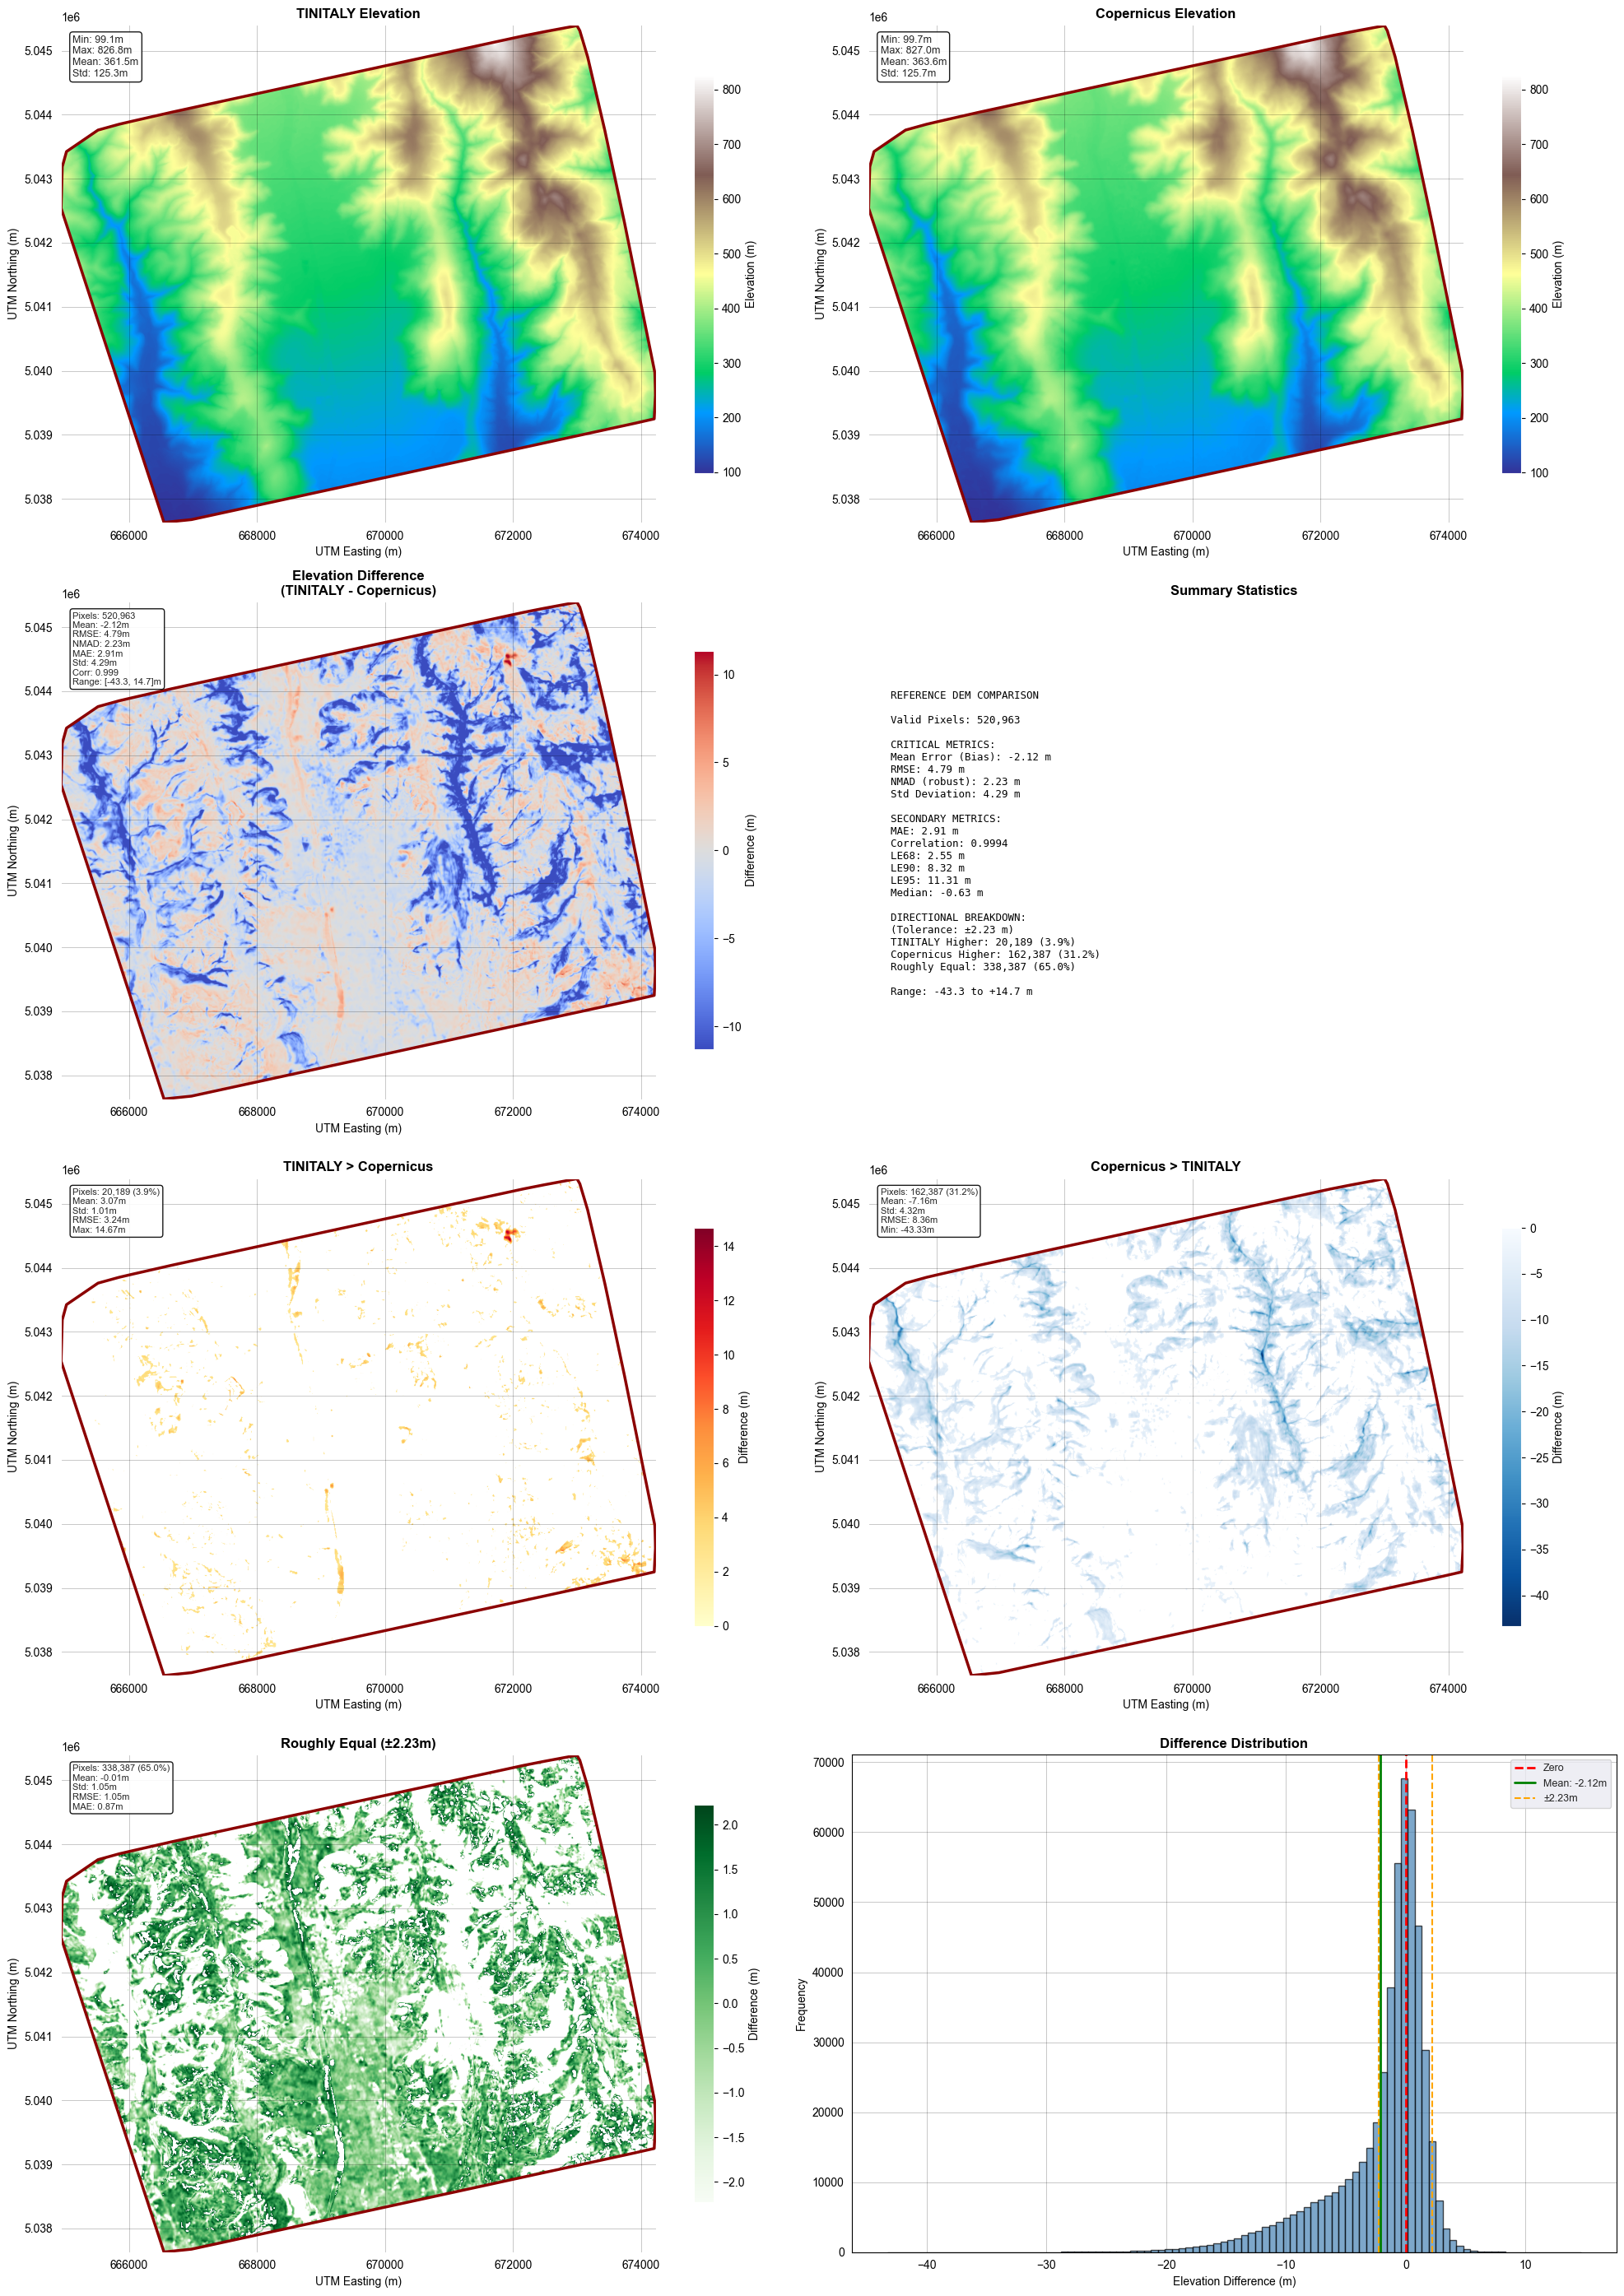

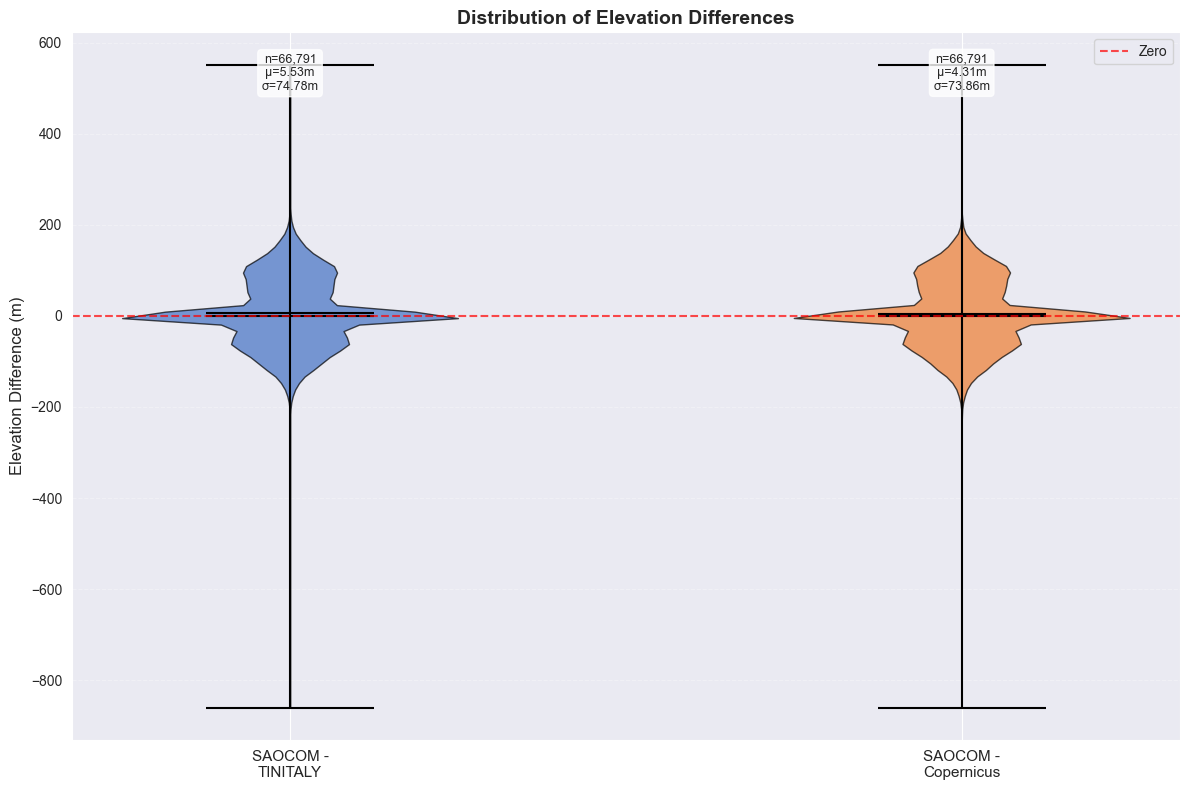

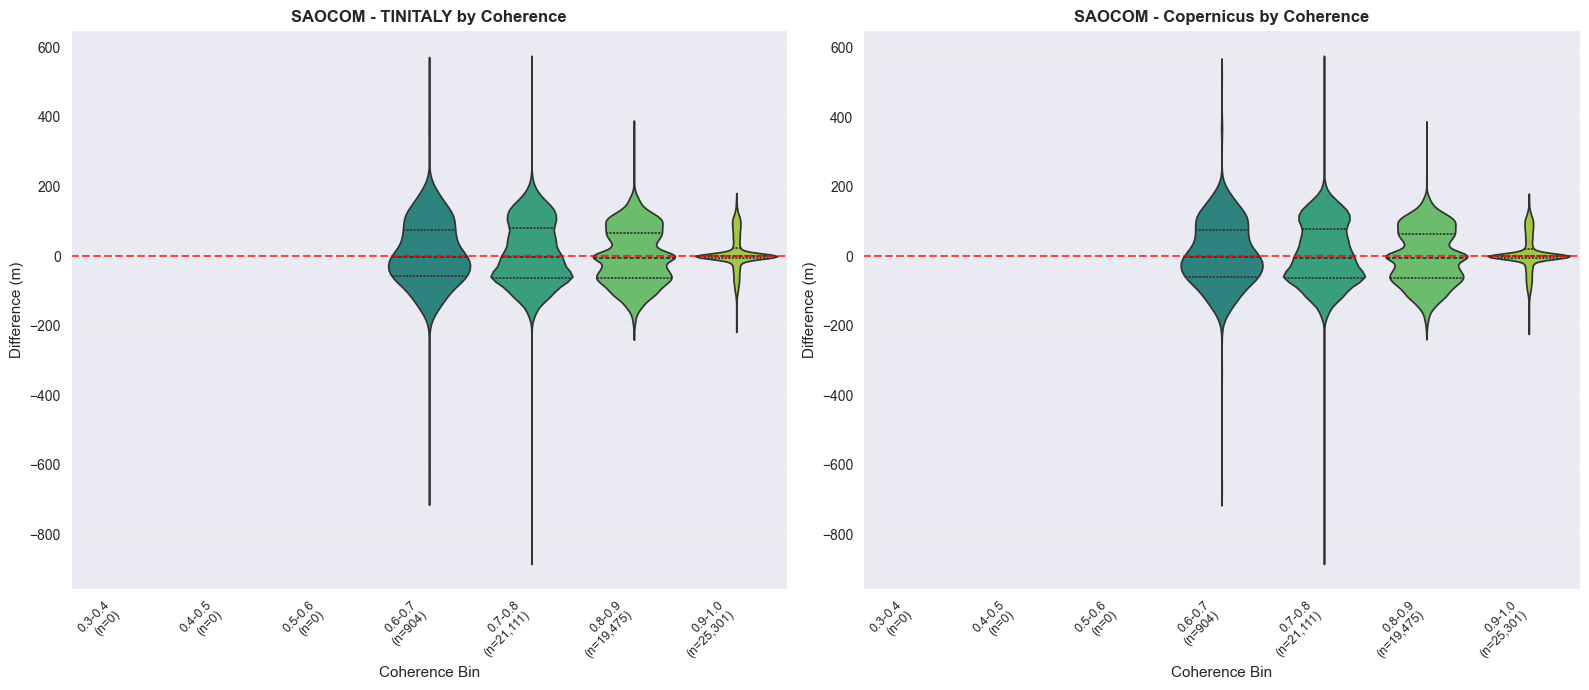


VIOLIN PLOT SUMMARY STATISTICS
         Comparison N Points    Mean  Median Std Dev    RMSE             Range
  SAOCOM - TINITALY   66,791 +5.53 m -0.14 m 74.78 m 74.98 m [-860.5, 551.0] m
SAOCOM - Copernicus   66,791 +4.31 m -0.16 m 73.86 m 73.99 m [-860.8, 551.8] m


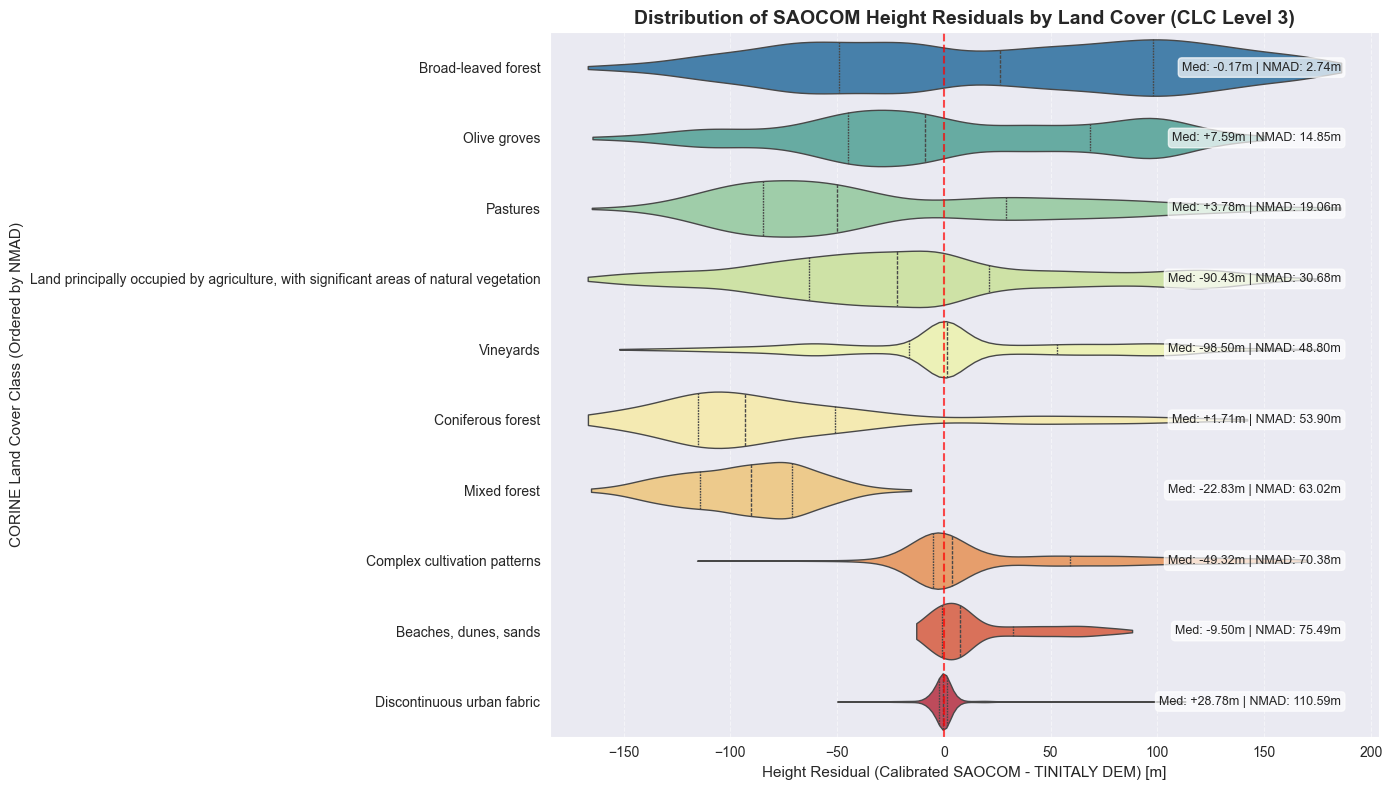

Violin Plot for Level 3 Land Cover classes generated successfully.


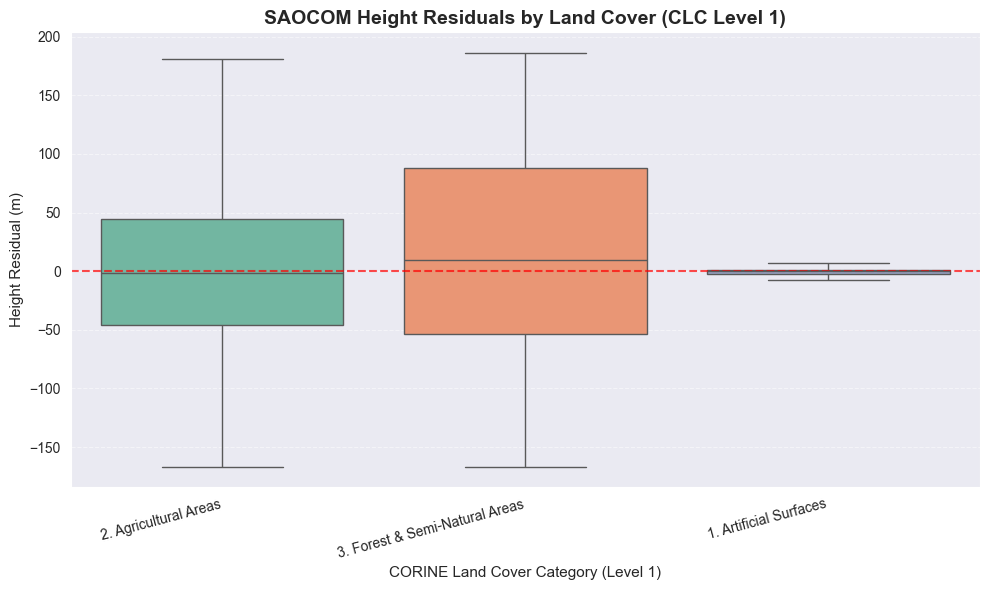

Box Plot for Level 1 Land Cover categories generated successfully.


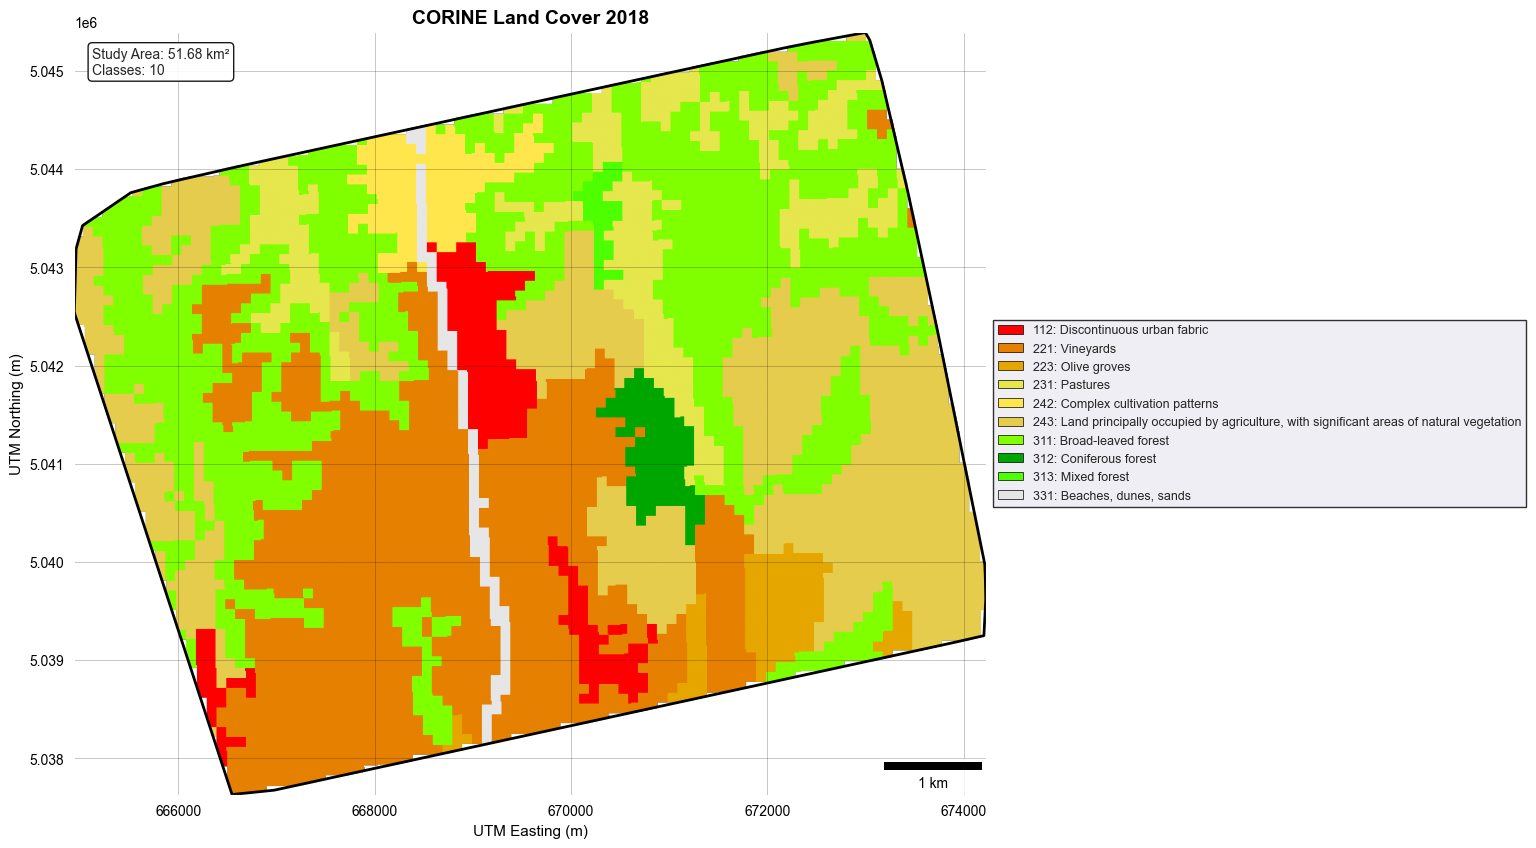


CORINE Land Cover Map:
  Total classes present: 10
  Study area: 51.68 km²


In [246]:
# =============================================================================
# COMPREHENSIVE REFERENCE DEM COMPARISON VISUALIZATION
# =============================================================================
fig, axes = plt.subplots(4, 2, figsize=(20, 28), facecolor='white')

extent = [xmin_grid, xmax_grid, ymin_grid, ymax_grid]

# Plot 1: TINITALY elevation
ax = axes[0, 0]
ax.set_facecolor('white')
tinitaly_display = np.ma.masked_where(tinitaly_data == NODATA, tinitaly_data)
cmap1 = plt.cm.terrain.copy()
cmap1.set_bad(color='white', alpha=0)
im1 = ax.imshow(tinitaly_display, cmap=cmap1, origin='upper', extent=extent)
hull_gdf.boundary.plot(ax=ax, color='darkred', linewidth=2.5, label='Study Area')
ax.set_title('TINITALY Elevation', fontweight='bold', fontsize=12, color='black')
ax.set_xlabel('UTM Easting (m)', color='black')
ax.set_ylabel('UTM Northing (m)', color='black')
ax.grid(True, color='black', alpha=0.3, linewidth=0.5)
ax.tick_params(colors='black')
cbar1 = plt.colorbar(im1, ax=ax, label='Elevation (m)', shrink=0.8)
cbar1.ax.yaxis.label.set_color('black')
cbar1.ax.tick_params(colors='black')
stats1 = f"""Min: {np.nanmin(tinitaly_display):.1f}m
Max: {np.nanmax(tinitaly_display):.1f}m
Mean: {np.nanmean(tinitaly_display):.1f}m
Std: {np.nanstd(tinitaly_display):.1f}m"""
ax.text(0.02, 0.98, stats1, transform=ax.transAxes, fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))

# Plot 2: Copernicus elevation
ax = axes[0, 1]
ax.set_facecolor('white')
copernicus_display = np.ma.masked_where(copernicus_data == NODATA, copernicus_data)
cmap2 = plt.cm.terrain.copy()
cmap2.set_bad(color='white', alpha=0)
im2 = ax.imshow(copernicus_display, cmap=cmap2, origin='upper', extent=extent)
hull_gdf.boundary.plot(ax=ax, color='darkred', linewidth=2.5, label='Study Area')
ax.set_title('Copernicus Elevation', fontweight='bold', fontsize=12, color='black')
ax.set_xlabel('UTM Easting (m)', color='black')
ax.set_ylabel('UTM Northing (m)', color='black')
ax.grid(True, color='black', alpha=0.3, linewidth=0.5)
ax.tick_params(colors='black')
cbar2 = plt.colorbar(im2, ax=ax, label='Elevation (m)', shrink=0.8)
cbar2.ax.yaxis.label.set_color('black')
cbar2.ax.tick_params(colors='black')
stats2 = f"""Min: {np.nanmin(copernicus_display):.1f}m
Max: {np.nanmax(copernicus_display):.1f}m
Mean: {np.nanmean(copernicus_display):.1f}m
Std: {np.nanstd(copernicus_display):.1f}m"""
ax.text(0.02, 0.98, stats2, transform=ax.transAxes, fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))

# Plot 3: Difference map (full)
ax = axes[1, 0]
ax.set_facecolor('white')
diff_display = np.ma.masked_where(~valid_mask, elevation_diff)
diff_limit = np.percentile(np.abs(valid_diffs), 95)
cmap3 = plt.cm.coolwarm.copy()
cmap3.set_bad(color='white', alpha=0)
im3 = ax.imshow(diff_display, cmap=cmap3, origin='upper', extent=extent,
                vmin=-diff_limit, vmax=diff_limit)
hull_gdf.boundary.plot(ax=ax, color='darkred', linewidth=2.5, label='Study Area')
ax.set_title(f'Elevation Difference\n(TINITALY - Copernicus)', fontweight='bold', fontsize=12, color='black')
ax.set_xlabel('UTM Easting (m)', color='black')
ax.set_ylabel('UTM Northing (m)', color='black')
ax.grid(True, color='black', alpha=0.3, linewidth=0.5)
ax.tick_params(colors='black')
cbar3 = plt.colorbar(im3, ax=ax, label='Difference (m)', shrink=0.8)
cbar3.ax.yaxis.label.set_color('black')
cbar3.ax.tick_params(colors='black')
stats3 = f"""Pixels: {valid_pixels:,}
Mean: {ref_metrics['mean_diff']:+.2f}m
RMSE: {ref_metrics['rmse']:.2f}m
NMAD: {ref_metrics['nmad']:.2f}m
MAE: {ref_metrics['mae']:.2f}m
Std: {ref_metrics['std_diff']:.2f}m
Corr: {ref_metrics['correlation']:.3f}
Range: [{ref_metrics['min_diff']:.1f}, {ref_metrics['max_diff']:.1f}]m"""
ax.text(0.02, 0.98, stats3, transform=ax.transAxes, fontsize=8, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))

# Plot 4: Statistics summary
ax = axes[1, 1]
ax.set_facecolor('white')
le68 = np.percentile(np.abs(valid_diffs), 68.27)
le90 = np.percentile(np.abs(valid_diffs), 90)
le95 = np.percentile(np.abs(valid_diffs), 95)
stats_text = f"""REFERENCE DEM COMPARISON

Valid Pixels: {valid_pixels:,}

CRITICAL METRICS:
Mean Error (Bias): {ref_metrics['mean_diff']:+.2f} m
RMSE: {ref_metrics['rmse']:.2f} m
NMAD (robust): {ref_metrics['nmad']:.2f} m
Std Deviation: {ref_metrics['std_diff']:.2f} m

SECONDARY METRICS:
MAE: {ref_metrics['mae']:.2f} m
Correlation: {ref_metrics['correlation']:.4f}
LE68: {le68:.2f} m
LE90: {le90:.2f} m
LE95: {le95:.2f} m
Median: {ref_metrics['median_diff']:+.2f} m

DIRECTIONAL BREAKDOWN:
(Tolerance: ±{equal_tolerance:.2f} m)
TINITALY Higher: {higher_pixels:,} ({pct_higher:.1f}%)
Copernicus Higher: {lower_pixels:,} ({pct_lower:.1f}%)
Roughly Equal: {equal_pixels:,} ({pct_equal:.1f}%)

Range: {ref_metrics['min_diff']:+.1f} to {ref_metrics['max_diff']:+.1f} m
"""
ax.text(0.05, 0.5, stats_text, transform=ax.transAxes,
        fontfamily='monospace', fontsize=9, verticalalignment='center', color='black')
ax.axis('off')
ax.set_title('Summary Statistics', fontweight='bold', fontsize=12, color='black')

# Plot 5: Where TINITALY > Copernicus
ax = axes[2, 0]
ax.set_facecolor('white')
cmap5 = plt.cm.YlOrRd.copy()
cmap5.set_bad(color='white', alpha=0)
im5 = ax.imshow(tinitaly_higher_data, cmap=cmap5, origin='upper', extent=extent,
                vmin=0, vmax=np.nanmax(tinitaly_higher_data))
hull_gdf.boundary.plot(ax=ax, color='darkred', linewidth=2.5, label='Study Area')
ax.set_title(f'TINITALY > Copernicus', fontweight='bold', fontsize=12, color='black')
ax.set_xlabel('UTM Easting (m)', color='black')
ax.set_ylabel('UTM Northing (m)', color='black')
ax.grid(True, color='black', alpha=0.3, linewidth=0.5)
ax.tick_params(colors='black')
cbar5 = plt.colorbar(im5, ax=ax, label='Difference (m)', shrink=0.8)
cbar5.ax.yaxis.label.set_color('black')
cbar5.ax.tick_params(colors='black')
higher_vals = tinitaly_higher_data[~np.isnan(tinitaly_higher_data)]
stats5 = f"""Pixels: {higher_pixels:,} ({pct_higher:.1f}%)
Mean: {np.mean(higher_vals):.2f}m
Std: {np.std(higher_vals):.2f}m
RMSE: {np.sqrt(np.mean(higher_vals**2)):.2f}m
Max: {np.max(higher_vals):.2f}m"""
ax.text(0.02, 0.98, stats5, transform=ax.transAxes, fontsize=8, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))

# Plot 6: Where TINITALY < Copernicus
ax = axes[2, 1]
ax.set_facecolor('white')
cmap6 = plt.cm.Blues_r.copy()
cmap6.set_bad(color='white', alpha=0)
im6 = ax.imshow(tinitaly_lower_data, cmap=cmap6, origin='upper', extent=extent,
                vmin=np.nanmin(tinitaly_lower_data), vmax=0)
hull_gdf.boundary.plot(ax=ax, color='darkred', linewidth=2.5, label='Study Area')
ax.set_title(f'Copernicus > TINITALY', fontweight='bold', fontsize=12, color='black')
ax.set_xlabel('UTM Easting (m)', color='black')
ax.set_ylabel('UTM Northing (m)', color='black')
ax.grid(True, color='black', alpha=0.3, linewidth=0.5)
ax.tick_params(colors='black')
cbar6 = plt.colorbar(im6, ax=ax, label='Difference (m)', shrink=0.8)
cbar6.ax.yaxis.label.set_color('black')
cbar6.ax.tick_params(colors='black')
lower_vals = tinitaly_lower_data[~np.isnan(tinitaly_lower_data)]
stats6 = f"""Pixels: {lower_pixels:,} ({pct_lower:.1f}%)
Mean: {np.mean(lower_vals):.2f}m
Std: {np.std(lower_vals):.2f}m
RMSE: {np.sqrt(np.mean(lower_vals**2)):.2f}m
Min: {np.min(lower_vals):.2f}m"""
ax.text(0.02, 0.98, stats6, transform=ax.transAxes, fontsize=8, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))

# Plot 7: Where roughly equal
ax = axes[3, 0]
ax.set_facecolor('white')
cmap7 = plt.cm.Greens.copy()
cmap7.set_bad(color='white', alpha=0)
im7 = ax.imshow(roughly_equal_data, cmap=cmap7, origin='upper', extent=extent,
                vmin=-equal_tolerance, vmax=equal_tolerance)
hull_gdf.boundary.plot(ax=ax, color='darkred', linewidth=2.5, label='Study Area')
ax.set_title(f'Roughly Equal (±{equal_tolerance:.2f}m)', fontweight='bold', fontsize=12, color='black')
ax.set_xlabel('UTM Easting (m)', color='black')
ax.set_ylabel('UTM Northing (m)', color='black')
ax.grid(True, color='black', alpha=0.3, linewidth=0.5)
ax.tick_params(colors='black')
cbar7 = plt.colorbar(im7, ax=ax, label='Difference (m)', shrink=0.8)
cbar7.ax.yaxis.label.set_color('black')
cbar7.ax.tick_params(colors='black')
equal_vals = roughly_equal_data[~np.isnan(roughly_equal_data)]
stats7 = f"""Pixels: {equal_pixels:,} ({pct_equal:.1f}%)
Mean: {np.mean(equal_vals):.2f}m
Std: {np.std(equal_vals):.2f}m
RMSE: {np.sqrt(np.mean(equal_vals**2)):.2f}m
MAE: {np.mean(np.abs(equal_vals)):.2f}m"""
ax.text(0.02, 0.98, stats7, transform=ax.transAxes, fontsize=8, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))

# Plot 8: Histogram of differences
ax = axes[3, 1]
ax.set_facecolor('white')
ax.hist(valid_diffs, bins=100, alpha=0.7, color='steelblue', edgecolor='black')
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
ax.axvline(ref_metrics['mean_diff'], color='green', linestyle='-', linewidth=2,
           label=f'Mean: {ref_metrics["mean_diff"]:+.2f}m')
ax.axvline(equal_tolerance, color='orange', linestyle='--', linewidth=1.5,
           label=f'±{equal_tolerance:.2f}m')
ax.axvline(-equal_tolerance, color='orange', linestyle='--', linewidth=1.5)
ax.set_xlabel('Elevation Difference (m)', color='black')
ax.set_ylabel('Frequency', color='black')
ax.set_title('Difference Distribution', fontweight='bold', fontsize=12, color='black')
ax.tick_params(colors='black')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3, color='black', linewidth=0.5)
for spine in ax.spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

# =============================================================================
# 1. PREPARE DIFFERENCE DATA
# =============================================================================
# Calculate differences using calibrated SAOCOM heights
saocom_gdf['diff_tinitaly'] = saocom_gdf['HEIGHT_ABSOLUTE_TIN'] - saocom_gdf['tinitaly_height']
saocom_gdf['diff_copernicus'] = saocom_gdf['HEIGHT_ABSOLUTE_COP'] - saocom_gdf['copernicus_height']

# Create coherence bins if not already present
if 'coherence_bin' not in saocom_gdf.columns:
    coherence_bins = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    coherence_labels = [f"{coherence_bins[i]:.1f}-{coherence_bins[i+1]:.1f}"
                        for i in range(len(coherence_bins)-1)]
    saocom_gdf['coherence_bin'] = pd.cut(saocom_gdf['COHER'],
                                         bins=coherence_bins,
                                         labels=coherence_labels,
                                         include_lowest=True)

# =============================================================================
# 2. BASIC VIOLIN PLOTS - ALL REFERENCE COMPARISONS
# =============================================================================
fig, ax = plt.subplots(1, 1, figsize=(12, 8), facecolor='white')

# Prepare data
plot_data = pd.DataFrame({
    'SAOCOM - TINITALY': saocom_gdf['diff_tinitaly'],
    'SAOCOM - Copernicus': saocom_gdf['diff_copernicus']
})

# Create violin plot
parts = ax.violinplot([plot_data['SAOCOM - TINITALY'].dropna(),
                       plot_data['SAOCOM - Copernicus'].dropna()],
                      positions=[1, 2],
                      showmeans=True,
                      showmedians=True,
                      showextrema=True)

# Color the violins
colors = ['#4472C4', '#ED7D31']
for pc, color in zip(parts['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)
    pc.set_edgecolor('black')

# Style other elements
for partname in ('cbars', 'cmins', 'cmaxes', 'cmedians', 'cmeans'):
    if partname in parts:
        parts[partname].set_edgecolor('black')
        parts[partname].set_linewidth(1.5)

ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Zero')
ax.set_xticks([1, 2])
ax.set_xticklabels(['SAOCOM -\nTINITALY', 'SAOCOM -\nCopernicus'], fontsize=11)
ax.set_ylabel('Elevation Difference (m)', fontsize=12)
ax.set_title('Distribution of Elevation Differences', fontweight='bold', fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.legend()

# Add statistics
for i, col in enumerate(['SAOCOM - TINITALY', 'SAOCOM - Copernicus'], 1):
    data = plot_data[col].dropna()
    stats_text = f"n={len(data):,}\nμ={data.mean():.2f}m\nσ={data.std():.2f}m"
    ax.text(i, data.max()*0.9, stats_text, ha='center', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# =============================================================================
# 3. VIOLIN PLOTS BY COHERENCE BINS
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 7), facecolor='white')

for idx, (col, title) in enumerate([('diff_tinitaly', 'SAOCOM - TINITALY'),
                                     ('diff_copernicus', 'SAOCOM - Copernicus')]):
    ax = axes[idx]

    # Filter data with valid coherence bins and differences
    plot_df = saocom_gdf[saocom_gdf['coherence_bin'].notna() &
                         saocom_gdf[col].notna()].copy()

    if len(plot_df) > 0:
        sns.violinplot(x='coherence_bin', y=col, data=plot_df,
                      inner='quartile', palette='viridis', ax=ax)

        ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
        ax.set_xlabel('Coherence Bin', fontsize=11)
        ax.set_ylabel('Difference (m)', fontsize=11)
        ax.set_title(f'{title} by Coherence', fontweight='bold', fontsize=12)
        ax.grid(axis='y', linestyle='--', alpha=0.3)

        # Add sample counts
        bin_counts = plot_df['coherence_bin'].value_counts().sort_index()
        labels = [f"{label}\n(n={bin_counts.get(label, 0):,})"
                 for label in coherence_labels]
        ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)

plt.tight_layout()
plt.show()

# =============================================================================
# 4. SUMMARY STATISTICS TABLE
# =============================================================================
summary_stats = []

for comparison in ['diff_tinitaly', 'diff_copernicus']:
    data = saocom_gdf[comparison].dropna()
    name = 'SAOCOM - TINITALY' if 'tinitaly' in comparison else 'SAOCOM - Copernicus'

    summary_stats.append({
        'Comparison': name,
        'N Points': f"{len(data):,}",
        'Mean': f"{data.mean():+.2f} m",
        'Median': f"{data.median():+.2f} m",
        'Std Dev': f"{data.std():.2f} m",
        'RMSE': f"{np.sqrt((data**2).mean()):.2f} m",
        'Range': f"[{data.min():.1f}, {data.max():.1f}] m"
    })

summary_df = pd.DataFrame(summary_stats)
print("\n" + "="*80)
print("VIOLIN PLOT SUMMARY STATISTICS")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)


# =============================================================================
# 2. GENERATE VIOLIN PLOT (Level 3 - Detailed Performance)
# =============================================================================
plt.figure(figsize=(14, 8), facecolor='white')

# Use violin plot for distribution shape and box plot for robust statistics
sns.violinplot(
    x='diff_tinitaly',
    y='LC_Label',
    data=plot_df_L3_filtered.sort_values('LC_Label', ascending=False), # Plotting worst (top) to best (bottom)
    inner='quartile', # Show quartiles
    palette='Spectral_r',
    orient='h',
    linewidth=1.0,
    cut=0 # Don't extend beyond data points
)

# Add a vertical line at zero error
plt.axvline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)

# Set labels and title
plt.title(
    f'Distribution of SAOCOM Height Residuals by Land Cover (CLC Level 3)',
    fontweight='bold',
    fontsize=14
)
plt.xlabel('Height Residual (Calibrated SAOCOM - TINITALY DEM) [m]', fontsize=11)
plt.ylabel('CORINE Land Cover Class (Ordered by NMAD)', fontsize=11)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Add NMAD and Median labels
for i, label in enumerate(nmad_order[::-1]):
    stats = lc_height_stats_final[lc_height_stats_final['LC_Label'] == label].iloc[0]
    nmad_m = stats['NMAD_m']
    median_diff = stats['Median_Diff_m']
    # Place text annotation to the right of the plot
    plt.text(q_high, i,
             f'Med: {median_diff:+.2f}m | NMAD: {nmad_m:.2f}m',
             verticalalignment='center',
             horizontalalignment='right',
             fontsize=9,
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7)
            )

plt.tight_layout()
plt.show()
print("Violin Plot for Level 3 Land Cover classes generated successfully.")

# =============================================================================
# 3. GENERATE BOX PLOT (Level 1 - Broad Comparison)
# =============================================================================
plt.figure(figsize=(10, 6), facecolor='white')

# Use box plot for a cleaner Level 1 aggregation
sns.boxplot(
    x='LC_Level_1',
    y='diff_tinitaly',
    data=plot_df_L3_filtered,
    palette='Set2',
    linewidth=1.0,
    showfliers=False # Do not show outliers already filtered
)

# Add a horizontal line at zero error
plt.axhline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)

# Set labels and title
plt.title(
    'SAOCOM Height Residuals by Land Cover (CLC Level 1)',
    fontweight='bold',
    fontsize=14
)
plt.xlabel('CORINE Land Cover Category (Level 1)', fontsize=11)
plt.ylabel('Height Residual (m)', fontsize=11)
plt.xticks(rotation=15, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
print("Box Plot for Level 1 Land Cover categories generated successfully.")

# =============================================================================
# CORINE LAND COVER VISUALIZATION
# =============================================================================
fig, ax = plt.subplots(figsize=(14, 10), facecolor='white')
ax.set_facecolor('white')

# Get extent
extent = [xmin_grid, xmax_grid, ymin_grid, ymax_grid]

# Mask NoData/zero values for transparency
corine_display = np.ma.masked_where((corine_10m == 0) | (corine_10m == 255), corine_10m)

# Get unique classes in study area
unique_codes = np.unique(corine_display.compressed())

# Create colormap for present classes only
colors_list = [CORINE_COLORS_MPL.get(code, (0.5, 0.5, 0.5)) for code in unique_codes]
cmap = ListedColormap(colors_list)
norm = BoundaryNorm(boundaries=np.append(unique_codes, unique_codes[-1]+1) - 0.5,
                    ncolors=len(unique_codes))

# Plot CORINE
im = ax.imshow(corine_display, cmap=cmap, norm=norm, origin='upper', extent=extent)

# Add study area boundary
hull_gdf.boundary.plot(ax=ax, color='black', linewidth=2, label='Study Area')

# Labels and title
ax.set_xlabel('UTM Easting (m)', fontsize=11, color='black')
ax.set_ylabel('UTM Northing (m)', fontsize=11, color='black')
ax.set_title('CORINE Land Cover 2018', fontweight='bold', fontsize=14, color='black')
ax.tick_params(colors='black')
ax.grid(True, alpha=0.3, linewidth=0.5, color='black')

# Create legend with only present classes
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=CORINE_COLORS_MPL[code],
                                 edgecolor='black', linewidth=0.5,
                                 label=f"{code}: {CORINE_CLASSES.get(code, 'Unknown')}")
                   for code in sorted(unique_codes)]

ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5),
          fontsize=9, frameon=True, fancybox=False, edgecolor='black')

# Add scale bar
scalebar = ScaleBar(1, location='lower right', box_alpha=0.8, color='black')
ax.add_artist(scalebar)

# Add statistics box
total_area_km2 = np.sum(study_area_mask) * 0.0001
stats_text = f"Study Area: {total_area_km2:.2f} km²\nClasses: {len(unique_codes)}"
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white',
        alpha=0.9, edgecolor='black'))

plt.tight_layout()
plt.show()

print(f"\nCORINE Land Cover Map:")
print(f"  Total classes present: {len(unique_codes)}")
print(f"  Study area: {total_area_km2:.2f} km²")

In [247]:
# =============================================================================
# INDIVIDUAL CLASS OVERLAY MAPS
# =============================================================================
from matplotlib.patches import Patch

# Create one map per significant class
for lc_code in sorted(significant_classes):
    fig, ax = plt.subplots(1, 1, figsize=(12, 10), facecolor='white')

    # Display Sentinel RGB as background
    ax.imshow(sentinel_rgb_norm, extent=[xmin_grid, xmax_grid, ymin_grid, ymax_grid],
              origin='upper')

    # Create mask for this land cover class
    lc_mask = (corine_10m == lc_code)

    # Vectorize to get boundaries
    mask_shapes = shapes(lc_mask.astype(np.uint8), mask=lc_mask, transform=target_transform)

    # Convert to polygons and plot with visible outlines
    polys = [shape(geom) for geom, val in mask_shapes if val == 1]

    if polys:
        # Plot filled polygons with transparency
        for poly in polys:
            if poly.is_valid:
                x, y = poly.exterior.xy
                # Fill with semi-transparent color
                ax.fill(x, y, color='cyan', alpha=0.3, edgecolor='none')
                # Bold outline with contrasting colors
                ax.plot(x, y, color='black', linewidth=3, alpha=0.8)
                ax.plot(x, y, color='cyan', linewidth=1.5, alpha=1.0)

    # Add study area boundary with dashed line
    for geom in hull_gdf.geometry:
        x, y = geom.exterior.xy
        ax.plot(x, y, color='white', linewidth=3, linestyle='--', alpha=0.8)
        ax.plot(x, y, color='red', linewidth=1.5, linestyle='--', alpha=1.0)

    # Calculate statistics
    area_km2 = lc_counts[lc_code] * (GRID_SIZE**2) / 1e6
    pct_area = 100 * lc_counts[lc_code] / np.sum(corine_10m != 0)

    # Title with statistics
    class_name = CORINE_CLASSES.get(lc_code, f'Class {lc_code}')
    ax.set_title(f'Land Cover: {class_name}\n'
                 f'Code {lc_code} | Area: {area_km2:.1f} km² ({pct_area:.1f}%)',
                 fontweight='bold', fontsize=12, color='white',
                 bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))

    ax.set_xlabel('UTM Easting (m)', fontsize=10, color='white')
    ax.set_ylabel('UTM Northing (m)', fontsize=10, color='white')
    ax.tick_params(colors='white')
    ax.grid(True, alpha=0.3, color='white', linewidth=0.5)

    # Legend
    legend_elements = [
        Patch(facecolor='cyan', edgecolor='black', linewidth=2, alpha=0.5, label=class_name),
        Patch(facecolor='none', edgecolor='red', linestyle='--', linewidth=2, label='Study Area')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=9,
              framealpha=0.8, facecolor='black', edgecolor='white', labelcolor='white')

    # Dark background for better Sentinel visibility
    ax.set_facecolor('black')
    fig.patch.set_facecolor('black')

    plt.tight_layout()

    # Save
    safe_name = class_name.replace(' ', '_').replace(',', '').replace('/', '_')
    filename = f'landcover_{lc_code}_{safe_name}.png'
    plt.show()
    # plt.savefig(RESULTS_DIR / filename, dpi=300, bbox_inches='tight', facecolor='black')
    # plt.close()
    #
    # print(f"Saved: {filename}")

# print(f"\nGenerated {len(significant_classes)} individual land cover overlay maps")

NameError: name 'significant_classes' is not defined